In [106]:
import sys
sys.path.append('../')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.models import Ensemble, RandomForest
from src.test import load_processed_data, load_pretrained_model, load_best_params

DATASET = 'BTC-USD'
N_PERIODS = 252

## Buy-hold performances:

In [61]:
def compute_hit_rate(log_returns):
    hit_position = log_returns >= 0
    return (hit_position.sum() / len(hit_position)).item()


def compute_sharpe(log_returns, n_periods):
    log_returns = pd.Series(log_returns)
    mean = log_returns.mean()
    std = log_returns.std()
    return (n_periods * mean) / (std * np.sqrt(n_periods))


def compute_max_drawdown(log_returns):
    returns = pd.Series(np.exp(log_returns) - 1)
    cumulative = (returns + 1).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    dd = (cumulative / peak) - 1
    return dd.abs().max()

In [103]:
_, test_target, _ = load_processed_data(DATASET, partition='test')

# Print buy-hold performances on the test set:
print('Buy-Hold stratedy on {} test set achieves:'.format(DATASET))
print('     Hit-rate: {:.3f}'.format(compute_hit_rate(test_target)))
print('     Annualized sharpe ratio: {:.3f}'.format(compute_sharpe(test_target, N_PERIODS)))
print('     Max drawdown: {:.3f}'.format(compute_max_drawdown(test_target)))

Buy-Hold stratedy on SMI test set achieves:
     Hit-rate: 0.535
     Annualized sharpe ratio: 0.219
     Max drawdown: 0.224


## Mix model of different type trained on the same asset

In [111]:
class MixedTypeEnsemble(Ensemble):
    def __init__(self, train_lags, train_target):
        self.nb_models = 4
        self.nb_lags = train_lags.shape[1]
        self.device = 'cpu'
        
        self.models = []
        for model_type in ['NN', 'CNN', 'LSTM', 'RandomForest']:
            if model_type in ['NN', 'CNN', 'LSTM']:
                model = load_pretrained_model(model_type, DATASET)
            else:
                # Load best para mmax_features:
                _, param = load_best_params(model_type, DATASET)
                model = RandomForest(n_estimators=10000, random_state=0, max_features=param)
                model.train(train_lags, train_target)
            self.models.append(model)

    def forecast(self, lags):
        median_forecast = torch.zeros((lags.shape[0], self.nb_models))
        for i in range(self.nb_models-1):
            median_forecast[:,i] = self.models[i].forecast(lags).detach()
        median_forecast[:,-1] = torch.tensor(self.models[-1].forecast(lags))
        print(np.argmax(np.abs(median_forecast), axis=1).shape)
        median_forecast = median_forecast[np.argmax(np.abs(median_forecast), axis=1)]
        return median_forecast

Training Random Forest with n_estimators=10000 and max_features=0.10 ...
torch.Size([920])


RuntimeError: The size of tensor a (4) must match the size of tensor b (920) at non-singleton dimension 1

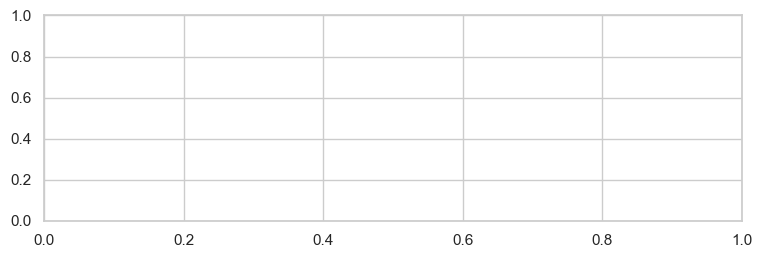

In [112]:
train_lags, train_target, train_dates = load_processed_data(DATASET, partition='train')
val_lags, val_target, val_dates = load_processed_data(DATASET, partition='val')
test_lags, test_target, test_dates = load_processed_data(DATASET, partition='test')

# Define number of periods per year to compute performance metrics:
if DATASET in ['BTC-USD', 'ETH-USD', 'XRP-USD']:
    n_periods = 365
else:
    n_periods = 252

mixed_model = MixedTypeEnsemble(train_lags, train_target)

# Plot cumulative sum of model's log-returns:
fig = plt.figure(figsize=(9, 6))
#fig.suptitle('Performances of {} on {}'.format(model_type, dataset), fontsize=14)
plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

sub1 = fig.add_subplot(2,2,(1,2))
mixed_model.test(train_lags, train_target, n_periods)
sub1.plot(train_dates, np.cumsum(mixed_model.log_returns))
sub1.plot(train_dates, np.cumsum(train_target.to('cpu')))
sub1.grid(True)
sub1.set_ylabel('Cumulated log-performances')
sub1.set_title('Train set')
#sub1.legend([model_type, 'Baseline'], loc="upper left")

sub2 = fig.add_subplot(2,2,3)
mixed_model.test(val_lags, val_target, n_periods)
sub2.plot(val_dates, np.cumsum(mixed_model.log_returns))
sub2.plot(val_dates, np.cumsum(val_target).to('cpu'))
sub2.tick_params(labelrotation=45)
sub2.grid(True)
sub2.set_ylabel('Cumulated log-performances')
sub2.set_title('Validation set')

sub3 = fig.add_subplot(2,2,4)
mixed_model.test(test_lags, test_target, n_periods)
sub3.plot(test_dates, np.cumsum(mixed_model.log_returns))
sub3.plot(test_dates, np.cumsum(test_target.to('cpu')))
sub3.tick_params(labelrotation=45)
sub3.grid(True)
sub3.set_title('Test set')

plt.show()

# Print trading performances on the test set:
print('Combination 1 on {} test set achieves:'.format(DATASET))
print('     Hit-rate: {:.3f}'.format(mixed_model.hit_rate))
print('     Annualized sharpe ratio: {:.3f}'.format(mixed_model.sharpe))
print('     Max drawdown: {:.3f}'.format(mixed_model.max_dd))